In [72]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprocessing as mp
from matplotlib.patches import Wedge, Circle

%matplotlib inline
import numpy as np
import pandas as pd 
from sklearn import datasets, metrics
import time as time
from sklearn import svm
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
import seaborn
import cProfile
from io import StringIO
import pstats
import psutil
import threading
cores = psutil.cpu_count()
from sklearn import metrics
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Funcion globlal lectura datos MNIST

In [4]:
def loadDataset(fileName, samples): 
    x = []  #Datos
    y = []  #Etiquetas
    train_data = pd.read_csv(fileName)  
    y = np.array(train_data.iloc[0:samples, 0])  #Etiquetas
    x = np.array(train_data.iloc[0:samples, 1:]) / 255  #Dividimos entre 255 las imagenes para que esten entre 0 y 1
    return x,y 

# Carga de datos en variables globales a los dos modelos

In [5]:
trainingSamples = 50000  
testingSamples = 10000
train_x, train_y = loadDataset("./mnist_train.csv", trainingSamples)  
test_x, test_y = loadDataset("./mnist_test.csv", testingSamples)

# Modelo SVC

## 1. Variables locales

In [6]:
cpu_percent_list_train_svc = []
memory_usage_list_train_svc = []
cpu_percent_list_test_svc = []
memory_usage_list_test_svc = []

## 2. Funcion para buscar los mejores hiperparámetros

In [7]:
def busqueda_de_atributos_svc(modelo):
    scoring = 'accuracy'
    param_grid = {
    'kernel': ["linear", "poly", "rbf", "sigmoid"],
    'degree': [1,2,3,4,5],
    'shrinking': [True, False],
    'probability':[True, False],
    'class_weight': ["balanced", None],
    'decision_function_shape': ["ovo","ovr"]
    }
    
    grid_search = HalvingGridSearchCV(estimator=modelo, param_grid=param_grid, scoring=scoring, cv=3)
    grid_search.fit(train_x, train_y)

    return [grid_search.best_estimator_,grid_search.best_params_]

## 3. Funciones para monitorización de cpu y ram

In [8]:
def lists_cpu_and_ram_svc_train():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_svc.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_svc.append(currentProcess.memory_percent())
        
def start_svc_train():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_svc_train)
    t.start()

def stop_svc_train():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

In [9]:
def lists_cpu_and_ram_svc_test():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_test_svc.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_svc.append(currentProcess.memory_percent())
        
def start_svc_test():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_svc_test)
    t.start()

def stop_svc_test():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

## 4. Funcion para entrenar y testear el modelo

In [10]:
def entrenamientoyresultados_svc(modelo):
    
    clf_svc = modelo
    #Empezamos a contar el tiempo de entrenamiento
    startTrainingTime_svc = time.time()
    
    # Entrenamiento
    start_svc_train()
    try:
        clf_svc.fit(train_x, train_y)
    finally:
        stop_svc_train()


    #Terminamos de contar el tiempo de entrenamiento
    endTrainingTime_svc = time.time()

    #Calculamos el tiempo de entrenamiento
    trainingTime_svc = endTrainingTime_svc - startTrainingTime_svc  

    validResults_svc = 0

    #Empezamos a contar el tiempo de testeo
    
    startTestingTime_svc = time.time()
    start_svc_test()
    try:
        for i in range(len(test_y)):

            expectedResult_svc = int(test_y[int(i)])

            result_svc = int(clf_svc.predict(test_x[int(i)].reshape(1, len(test_x[int(i)]))))


            outcome = "Fail"

            if result_svc == expectedResult_svc:

                validResults_svc = validResults_svc + 1 

                outcome = " OK "

            print("Nº ", i + 1, " | Expected result: ", expectedResult_svc, " | Obtained result: ", result_svc, " | ", outcome,
                  " | Accuracy: ", round((validResults_svc / (i + 1)) * 100, 2),
                  "%")  # Printing the results for each label in testing dataset
    finally:
        stop_svc_test()
    #Terminamos de contar el tiempo de testeo
    endTestingTime_svc = time.time()

    #Calculamos el tiempo de testeo
    testingTime_svc = endTestingTime_svc - startTestingTime_svc  # Calculation of testing time
    
    precision = round((validResults_svc / testingSamples) * 100, 2)
    
    return precision,trainingTime_svc, testingTime_svc,clf_svc

## 5. Resultados

In [11]:
#parametros = busqueda_de_atributos_svc(svm.SVC())

modelo_svc = svm.SVC(class_weight='balanced', decision_function_shape='ovo', degree=4,probability=True, shrinking=True)
resultados_svc = entrenamientoyresultados_svc(modelo_svc)

Nº  1  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  100.0 %
Nº  2  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  100.0 %
Nº  3  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  100.0 %
Nº  4  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  100.0 %
Nº  5  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  100.0 %
Nº  6  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  100.0 %
Nº  7  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  100.0 %
Nº  8  | Expected result:  5  | Obtained result:  6  |  Fail  | Accuracy:  87.5 %
Nº  9  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  88.89 %
Nº  10  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  90.0 %
Nº  11  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  90.91 %
Nº  12  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  91.67 %
Nº 

Nº  120  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  99.17 %
Nº  121  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  99.17 %
Nº  122  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  99.18 %
Nº  123  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  99.19 %
Nº  124  | Expected result:  7  | Obtained result:  4  |  Fail  | Accuracy:  98.39 %
Nº  125  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  98.4 %
Nº  126  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  98.41 %
Nº  127  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  98.43 %
Nº  128  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  98.44 %
Nº  129  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  98.45 %
Nº  130  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  98.46 %
Nº  131  | Expected result:  6  | Obtained result:  6  |   OK   | 

Nº  237  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  98.31 %
Nº  238  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  98.32 %
Nº  239  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  98.33 %
Nº  240  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  98.33 %
Nº  241  | Expected result:  9  | Obtained result:  8  |  Fail  | Accuracy:  97.93 %
Nº  242  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.93 %
Nº  243  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.94 %
Nº  244  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.95 %
Nº  245  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.96 %
Nº  246  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.97 %
Nº  247  | Expected result:  4  | Obtained result:  2  |  Fail  | Accuracy:  97.57 %
Nº  248  | Expected result:  4  | Obtained result:  4  |   OK   |

Nº  348  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.13 %
Nº  349  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.13 %
Nº  350  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.14 %
Nº  351  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.15 %
Nº  352  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.16 %
Nº  353  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.17 %
Nº  354  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.18 %
Nº  355  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.18 %
Nº  356  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.19 %
Nº  357  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.2 %
Nº  358  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.21 %
Nº  359  | Expected result:  9  | Obtained result:  9  |   OK   | 

Nº  467  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.0 %
Nº  468  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.01 %
Nº  469  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.01 %
Nº  470  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.02 %
Nº  471  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.03 %
Nº  472  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.03 %
Nº  473  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.04 %
Nº  474  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.05 %
Nº  475  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.05 %
Nº  476  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.06 %
Nº  477  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.06 %
Nº  478  | Expected result:  5  | Obtained result:  5  |   OK   | 

Nº  587  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.1 %
Nº  588  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.11 %
Nº  589  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.11 %
Nº  590  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.12 %
Nº  591  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.12 %
Nº  592  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.13 %
Nº  593  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.13 %
Nº  594  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.14 %
Nº  595  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.14 %
Nº  596  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.15 %
Nº  597  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.15 %
Nº  598  | Expected result:  9  | Obtained result:  9  |   OK   | 

Nº  707  | Expected result:  4  | Obtained result:  9  |  Fail  | Accuracy:  97.03 %
Nº  708  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.03 %
Nº  709  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.04 %
Nº  710  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.04 %
Nº  711  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.05 %
Nº  712  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.05 %
Nº  713  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.05 %
Nº  714  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.06 %
Nº  715  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.06 %
Nº  716  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.07 %
Nº  717  | Expected result:  0  | Obtained result:  6  |  Fail  | Accuracy:  96.93 %
Nº  718  | Expected result:  8  | Obtained result:  8  |   OK   |

Nº  826  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.09 %
Nº  827  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.1 %
Nº  828  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.1 %
Nº  829  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.1 %
Nº  830  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.11 %
Nº  831  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.11 %
Nº  832  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.12 %
Nº  833  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.12 %
Nº  834  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.12 %
Nº  835  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.13 %
Nº  836  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.13 %
Nº  837  | Expected result:  2  | Obtained result:  2  |   OK   | Ac

Nº  946  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.25 %
Nº  947  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.25 %
Nº  948  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.26 %
Nº  949  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.26 %
Nº  950  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.26 %
Nº  951  | Expected result:  5  | Obtained result:  4  |  Fail  | Accuracy:  97.16 %
Nº  952  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.16 %
Nº  953  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.17 %
Nº  954  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.17 %
Nº  955  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.17 %
Nº  956  | Expected result:  1  | Obtained result:  2  |  Fail  | Accuracy:  97.07 %
Nº  957  | Expected result:  3  | Obtained result:  3  |   OK   |

Nº  1064  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.99 %
Nº  1065  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.0 %
Nº  1066  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.0 %
Nº  1067  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.0 %
Nº  1068  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.0 %
Nº  1069  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.01 %
Nº  1070  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.01 %
Nº  1071  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.01 %
Nº  1072  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.01 %
Nº  1073  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.02 %
Nº  1074  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.02 %
Nº  1075  | Expected result:  1  | Obtained result:  1  | 

Nº  1183  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.13 %
Nº  1184  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.13 %
Nº  1185  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.13 %
Nº  1186  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.13 %
Nº  1187  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.14 %
Nº  1188  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.14 %
Nº  1189  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.14 %
Nº  1190  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.14 %
Nº  1191  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.15 %
Nº  1192  | Expected result:  9  | Obtained result:  4  |  Fail  | Accuracy:  97.06 %
Nº  1193  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.07 %
Nº  1194  | Expected result:  7  | Obtained result:  9

Nº  1303  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.7 %
Nº  1304  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.7 %
Nº  1305  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.7 %
Nº  1306  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.71 %
Nº  1307  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.71 %
Nº  1308  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.71 %
Nº  1309  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.72 %
Nº  1310  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.72 %
Nº  1311  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.72 %
Nº  1312  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.72 %
Nº  1313  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.73 %
Nº  1314  | Expected result:  4  | Obtained result:  4  |

Nº  1423  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.63 %
Nº  1424  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.63 %
Nº  1425  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.63 %
Nº  1426  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.63 %
Nº  1427  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.64 %
Nº  1428  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.64 %
Nº  1429  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.64 %
Nº  1430  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.64 %
Nº  1431  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.65 %
Nº  1432  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.65 %
Nº  1433  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.65 %
Nº  1434  | Expected result:  1  | Obtained result:  1

Nº  1542  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.63 %
Nº  1543  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.63 %
Nº  1544  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.63 %
Nº  1545  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.63 %
Nº  1546  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.64 %
Nº  1547  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.64 %
Nº  1548  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.64 %
Nº  1549  | Expected result:  4  | Obtained result:  2  |  Fail  | Accuracy:  96.58 %
Nº  1550  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.58 %
Nº  1551  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.58 %
Nº  1552  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.59 %
Nº  1553  | Expected result:  9  | Obtained result:  3

Nº  1661  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.63 %
Nº  1662  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.63 %
Nº  1663  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.63 %
Nº  1664  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.63 %
Nº  1665  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.64 %
Nº  1666  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.64 %
Nº  1667  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.64 %
Nº  1668  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.64 %
Nº  1669  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.64 %
Nº  1670  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.65 %
Nº  1671  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.65 %
Nº  1672  | Expected result:  5  | Obtained result:  5

Nº  1780  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.63 %
Nº  1781  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.63 %
Nº  1782  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.63 %
Nº  1783  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.63 %
Nº  1784  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.64 %
Nº  1785  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.64 %
Nº  1786  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.64 %
Nº  1787  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.64 %
Nº  1788  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.64 %
Nº  1789  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.65 %
Nº  1790  | Expected result:  2  | Obtained result:  7  |  Fail  | Accuracy:  96.59 %
Nº  1791  | Expected result:  1  | Obtained result:  1

Nº  1899  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.79 %
Nº  1900  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.79 %
Nº  1901  | Expected result:  9  | Obtained result:  4  |  Fail  | Accuracy:  96.74 %
Nº  1902  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.74 %
Nº  1903  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.74 %
Nº  1904  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.74 %
Nº  1905  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.75 %
Nº  1906  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.75 %
Nº  1907  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.75 %
Nº  1908  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.75 %
Nº  1909  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.75 %
Nº  1910  | Expected result:  5  | Obtained result:  5

Nº  2019  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.83 %
Nº  2020  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.83 %
Nº  2021  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.83 %
Nº  2022  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.83 %
Nº  2023  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.84 %
Nº  2024  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.84 %
Nº  2025  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.84 %
Nº  2026  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.84 %
Nº  2027  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.84 %
Nº  2028  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.84 %
Nº  2029  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.85 %
Nº  2030  | Expected result:  5  | Obtained result:  5

Nº  2138  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.45 %
Nº  2139  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.45 %
Nº  2140  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.45 %
Nº  2141  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.45 %
Nº  2142  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.45 %
Nº  2143  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.45 %
Nº  2144  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.46 %
Nº  2145  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.46 %
Nº  2146  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.46 %
Nº  2147  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.46 %
Nº  2148  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.46 %
Nº  2149  | Expected result:  8  | Obtained result:  8

Nº  2257  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.46 %
Nº  2258  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.46 %
Nº  2259  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.46 %
Nº  2260  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.46 %
Nº  2261  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.46 %
Nº  2262  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.46 %
Nº  2263  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.46 %
Nº  2264  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.47 %
Nº  2265  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.47 %
Nº  2266  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.47 %
Nº  2267  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.47 %
Nº  2268  | Expected result:  7  | Obtained result:  7

Nº  2376  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.46 %
Nº  2377  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.47 %
Nº  2378  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.47 %
Nº  2379  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.47 %
Nº  2380  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.47 %
Nº  2381  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.47 %
Nº  2382  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.47 %
Nº  2383  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.48 %
Nº  2384  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.48 %
Nº  2385  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.48 %
Nº  2386  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.48 %
Nº  2387  | Expected result:  9  | Obtained result:  1

Nº  2495  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.43 %
Nº  2496  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.43 %
Nº  2497  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.44 %
Nº  2498  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.44 %
Nº  2499  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.44 %
Nº  2500  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.44 %
Nº  2501  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.44 %
Nº  2502  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.44 %
Nº  2503  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.44 %
Nº  2504  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.45 %
Nº  2505  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.45 %
Nº  2506  | Expected result:  0  | Obtained result:  0

Nº  2614  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.48 %
Nº  2615  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.48 %
Nº  2616  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.48 %
Nº  2617  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.48 %
Nº  2618  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.49 %
Nº  2619  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.49 %
Nº  2620  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.49 %
Nº  2621  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.49 %
Nº  2622  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.49 %
Nº  2623  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.49 %
Nº  2624  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.49 %
Nº  2625  | Expected result:  2  | Obtained result:  2

Nº  2734  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.56 %
Nº  2735  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.56 %
Nº  2736  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.56 %
Nº  2737  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.57 %
Nº  2738  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.57 %
Nº  2739  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.57 %
Nº  2740  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.57 %
Nº  2741  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.57 %
Nº  2742  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.57 %
Nº  2743  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.57 %
Nº  2744  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.57 %
Nº  2745  | Expected result:  3  | Obtained result:  3

Nº  2854  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.67 %
Nº  2855  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.67 %
Nº  2856  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.67 %
Nº  2857  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.67 %
Nº  2858  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.68 %
Nº  2859  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.68 %
Nº  2860  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.68 %
Nº  2861  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.68 %
Nº  2862  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.68 %
Nº  2863  | Expected result:  9  | Obtained result:  4  |  Fail  | Accuracy:  96.65 %
Nº  2864  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.65 %
Nº  2865  | Expected result:  3  | Obtained result:  3

Nº  2973  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.64 %
Nº  2974  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.64 %
Nº  2975  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.64 %
Nº  2976  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.64 %
Nº  2977  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.64 %
Nº  2978  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.64 %
Nº  2979  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.64 %
Nº  2980  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.64 %
Nº  2981  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.65 %
Nº  2982  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.65 %
Nº  2983  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.65 %
Nº  2984  | Expected result:  1  | Obtained result:  1

Nº  3091  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.67 %
Nº  3092  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.67 %
Nº  3093  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.67 %
Nº  3094  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.67 %
Nº  3095  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.67 %
Nº  3096  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.67 %
Nº  3097  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.67 %
Nº  3098  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.68 %
Nº  3099  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.68 %
Nº  3100  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.68 %
Nº  3101  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.68 %
Nº  3102  | Expected result:  5  | Obtained result:  5

Nº  3211  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.73 %
Nº  3212  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.73 %
Nº  3213  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.73 %
Nº  3214  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.73 %
Nº  3215  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.73 %
Nº  3216  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.74 %
Nº  3217  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.74 %
Nº  3218  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.74 %
Nº  3219  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.74 %
Nº  3220  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.74 %
Nº  3221  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.74 %
Nº  3222  | Expected result:  6  | Obtained result:  6

Nº  3331  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.85 %
Nº  3332  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.85 %
Nº  3333  | Expected result:  7  | Obtained result:  9  |  Fail  | Accuracy:  96.82 %
Nº  3334  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.82 %
Nº  3335  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.82 %
Nº  3336  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.82 %
Nº  3337  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.82 %
Nº  3338  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.82 %
Nº  3339  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.83 %
Nº  3340  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.83 %
Nº  3341  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.83 %
Nº  3342  | Expected result:  6  | Obtained result:  6

Nº  3451  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.9 %
Nº  3452  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.9 %
Nº  3453  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.9 %
Nº  3454  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.9 %
Nº  3455  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.9 %
Nº  3456  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.9 %
Nº  3457  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.9 %
Nº  3458  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.91 %
Nº  3459  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.91 %
Nº  3460  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.91 %
Nº  3461  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.91 %
Nº  3462  | Expected result:  5  | Obtained result:  5  |   O

Nº  3570  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.78 %
Nº  3571  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.78 %
Nº  3572  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.78 %
Nº  3573  | Expected result:  7  | Obtained result:  2  |  Fail  | Accuracy:  96.75 %
Nº  3574  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.75 %
Nº  3575  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.76 %
Nº  3576  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.76 %
Nº  3577  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.76 %
Nº  3578  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.76 %
Nº  3579  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.76 %
Nº  3580  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.76 %
Nº  3581  | Expected result:  0  | Obtained result:  0

Nº  3690  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.83 %
Nº  3691  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.83 %
Nº  3692  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.83 %
Nº  3693  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.83 %
Nº  3694  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.83 %
Nº  3695  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.83 %
Nº  3696  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.83 %
Nº  3697  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.84 %
Nº  3698  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.84 %
Nº  3699  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.84 %
Nº  3700  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.84 %
Nº  3701  | Expected result:  3  | Obtained result:  3

Nº  3809  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.74 %
Nº  3810  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.75 %
Nº  3811  | Expected result:  2  | Obtained result:  3  |  Fail  | Accuracy:  96.72 %
Nº  3812  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.72 %
Nº  3813  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.72 %
Nº  3814  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.72 %
Nº  3815  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.72 %
Nº  3816  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.72 %
Nº  3817  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.73 %
Nº  3818  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.73 %
Nº  3819  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.73 %
Nº  3820  | Expected result:  9  | Obtained result:  9

Nº  3929  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.74 %
Nº  3930  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.74 %
Nº  3931  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.74 %
Nº  3932  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.74 %
Nº  3933  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.75 %
Nº  3934  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.75 %
Nº  3935  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.75 %
Nº  3936  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.75 %
Nº  3937  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.75 %
Nº  3938  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.75 %
Nº  3939  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.75 %
Nº  3940  | Expected result:  0  | Obtained result:  0

Nº  4049  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.76 %
Nº  4050  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.77 %
Nº  4051  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.77 %
Nº  4052  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.77 %
Nº  4053  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.77 %
Nº  4054  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.77 %
Nº  4055  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.77 %
Nº  4056  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.77 %
Nº  4057  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.77 %
Nº  4058  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.77 %
Nº  4059  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.77 %
Nº  4060  | Expected result:  4  | Obtained result:  4

Nº  4168  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.76 %
Nº  4169  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.76 %
Nº  4170  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.76 %
Nº  4171  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.76 %
Nº  4172  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.76 %
Nº  4173  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.76 %
Nº  4174  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.77 %
Nº  4175  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.77 %
Nº  4176  | Expected result:  2  | Obtained result:  7  |  Fail  | Accuracy:  96.74 %
Nº  4177  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.74 %
Nº  4178  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.74 %
Nº  4179  | Expected result:  1  | Obtained result:  1

Nº  4283  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.78 %
Nº  4284  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.78 %
Nº  4285  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.78 %
Nº  4286  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.78 %
Nº  4287  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.78 %
Nº  4288  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.78 %
Nº  4289  | Expected result:  2  | Obtained result:  7  |  Fail  | Accuracy:  96.76 %
Nº  4290  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.76 %
Nº  4291  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.76 %
Nº  4292  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.76 %
Nº  4293  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.76 %
Nº  4294  | Expected result:  9  | Obtained result:  9

Nº  4402  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.8 %
Nº  4403  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.8 %
Nº  4404  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.8 %
Nº  4405  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.8 %
Nº  4406  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.8 %
Nº  4407  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.8 %
Nº  4408  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.8 %
Nº  4409  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.8 %
Nº  4410  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.8 %
Nº  4411  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.8 %
Nº  4412  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.8 %
Nº  4413  | Expected result:  6  | Obtained result:  6  |   OK   

Nº  4517  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.83 %
Nº  4518  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.83 %
Nº  4519  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.84 %
Nº  4520  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.84 %
Nº  4521  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.84 %
Nº  4522  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.84 %
Nº  4523  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.84 %
Nº  4524  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.84 %
Nº  4525  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.84 %
Nº  4526  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.84 %
Nº  4527  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.84 %
Nº  4528  | Expected result:  3  | Obtained result:  3

Nº  4637  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.89 %
Nº  4638  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.9 %
Nº  4639  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.9 %
Nº  4640  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.9 %
Nº  4641  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.9 %
Nº  4642  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.9 %
Nº  4643  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.9 %
Nº  4644  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.9 %
Nº  4645  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.9 %
Nº  4646  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.9 %
Nº  4647  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.9 %
Nº  4648  | Expected result:  9  | Obtained result:  9  |   OK  

Nº  4756  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.93 %
Nº  4757  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.93 %
Nº  4758  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.93 %
Nº  4759  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.93 %
Nº  4760  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.93 %
Nº  4761  | Expected result:  9  | Obtained result:  7  |  Fail  | Accuracy:  96.91 %
Nº  4762  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.91 %
Nº  4763  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.91 %
Nº  4764  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.91 %
Nº  4765  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.92 %
Nº  4766  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.92 %
Nº  4767  | Expected result:  7  | Obtained result:  7

Nº  4876  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.92 %
Nº  4877  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.92 %
Nº  4878  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.92 %
Nº  4879  | Expected result:  8  | Obtained result:  6  |  Fail  | Accuracy:  96.91 %
Nº  4880  | Expected result:  0  | Obtained result:  8  |  Fail  | Accuracy:  96.89 %
Nº  4881  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.89 %
Nº  4882  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.89 %
Nº  4883  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.89 %
Nº  4884  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.89 %
Nº  4885  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.89 %
Nº  4886  | Expected result:  7  | Obtained result:  1  |  Fail  | Accuracy:  96.87 %
Nº  4887  | Expected result:  0  | Obtained result:  0

Nº  4995  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.9 %
Nº  4996  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.9 %
Nº  4997  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.9 %
Nº  4998  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.9 %
Nº  4999  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.9 %
Nº  5000  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  96.9 %
Nº  5001  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.9 %
Nº  5002  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.9 %
Nº  5003  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.9 %
Nº  5004  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.9 %
Nº  5005  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.9 %
Nº  5006  | Expected result:  0  | Obtained result:  0  |   OK   

Nº  5115  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.97 %
Nº  5116  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.97 %
Nº  5117  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  96.97 %
Nº  5118  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.97 %
Nº  5119  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.97 %
Nº  5120  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.97 %
Nº  5121  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.97 %
Nº  5122  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  96.97 %
Nº  5123  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.97 %
Nº  5124  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.98 %
Nº  5125  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.98 %
Nº  5126  | Expected result:  4  | Obtained result:  4

Nº  5235  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.04 %
Nº  5236  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.04 %
Nº  5237  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.04 %
Nº  5238  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.04 %
Nº  5239  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.04 %
Nº  5240  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.04 %
Nº  5241  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.04 %
Nº  5242  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.04 %
Nº  5243  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.04 %
Nº  5244  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.04 %
Nº  5245  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.04 %
Nº  5246  | Expected result:  7  | Obtained result:  7

Nº  5354  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.09 %
Nº  5355  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.09 %
Nº  5356  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.09 %
Nº  5357  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.09 %
Nº  5358  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.09 %
Nº  5359  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.09 %
Nº  5360  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.09 %
Nº  5361  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.09 %
Nº  5362  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.09 %
Nº  5363  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.09 %
Nº  5364  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.09 %
Nº  5365  | Expected result:  7  | Obtained result:  7

Nº  5474  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.13 %
Nº  5475  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.13 %
Nº  5476  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.13 %
Nº  5477  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.13 %
Nº  5478  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.13 %
Nº  5479  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.13 %
Nº  5480  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.14 %
Nº  5481  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.14 %
Nº  5482  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.14 %
Nº  5483  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.14 %
Nº  5484  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.14 %
Nº  5485  | Expected result:  7  | Obtained result:  7

Nº  5593  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.19 %
Nº  5594  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.19 %
Nº  5595  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.19 %
Nº  5596  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.19 %
Nº  5597  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.19 %
Nº  5598  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.2 %
Nº  5599  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.2 %
Nº  5600  | Expected result:  7  | Obtained result:  9  |  Fail  | Accuracy:  97.18 %
Nº  5601  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.18 %
Nº  5602  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.18 %
Nº  5603  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.18 %
Nº  5604  | Expected result:  1  | Obtained result:  1  

Nº  5713  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.22 %
Nº  5714  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.22 %
Nº  5715  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.22 %
Nº  5716  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.22 %
Nº  5717  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.22 %
Nº  5718  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.22 %
Nº  5719  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.22 %
Nº  5720  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.22 %
Nº  5721  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.22 %
Nº  5722  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.22 %
Nº  5723  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.22 %
Nº  5724  | Expected result:  3  | Obtained result:  3

Nº  5833  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.24 %
Nº  5834  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.24 %
Nº  5835  | Expected result:  7  | Obtained result:  9  |  Fail  | Accuracy:  97.22 %
Nº  5836  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.22 %
Nº  5837  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.22 %
Nº  5838  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.23 %
Nº  5839  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.23 %
Nº  5840  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.23 %
Nº  5841  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.23 %
Nº  5842  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.23 %
Nº  5843  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.23 %
Nº  5844  | Expected result:  6  | Obtained result:  6

Nº  5952  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.23 %
Nº  5953  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.23 %
Nº  5954  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.23 %
Nº  5955  | Expected result:  3  | Obtained result:  8  |  Fail  | Accuracy:  97.21 %
Nº  5956  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.21 %
Nº  5957  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.21 %
Nº  5958  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.21 %
Nº  5959  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.21 %
Nº  5960  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.21 %
Nº  5961  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.22 %
Nº  5962  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.22 %
Nº  5963  | Expected result:  6  | Obtained result:  6

Nº  6072  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.17 %
Nº  6073  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.17 %
Nº  6074  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.17 %
Nº  6075  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.17 %
Nº  6076  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.17 %
Nº  6077  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.17 %
Nº  6078  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.17 %
Nº  6079  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.17 %
Nº  6080  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.17 %
Nº  6081  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.17 %
Nº  6082  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.17 %
Nº  6083  | Expected result:  1  | Obtained result:  1

Nº  6191  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.19 %
Nº  6192  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.19 %
Nº  6193  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.19 %
Nº  6194  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.19 %
Nº  6195  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.19 %
Nº  6196  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.19 %
Nº  6197  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.19 %
Nº  6198  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.19 %
Nº  6199  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.19 %
Nº  6200  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.19 %
Nº  6201  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.19 %
Nº  6202  | Expected result:  1  | Obtained result:  1

Nº  6311  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.24 %
Nº  6312  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.24 %
Nº  6313  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.24 %
Nº  6314  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.24 %
Nº  6315  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.24 %
Nº  6316  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.25 %
Nº  6317  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.25 %
Nº  6318  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.25 %
Nº  6319  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.25 %
Nº  6320  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.25 %
Nº  6321  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.25 %
Nº  6322  | Expected result:  3  | Obtained result:  3

Nº  6430  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.29 %
Nº  6431  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.29 %
Nº  6432  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.29 %
Nº  6433  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.3 %
Nº  6434  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.3 %
Nº  6435  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.3 %
Nº  6436  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.3 %
Nº  6437  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.3 %
Nº  6438  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.3 %
Nº  6439  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.3 %
Nº  6440  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.3 %
Nº  6441  | Expected result:  7  | Obtained result:  7  |   OK

Nº  6550  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.33 %
Nº  6551  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.33 %
Nº  6552  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.33 %
Nº  6553  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.33 %
Nº  6554  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.33 %
Nº  6555  | Expected result:  8  | Obtained result:  9  |  Fail  | Accuracy:  97.32 %
Nº  6556  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.32 %
Nº  6557  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.32 %
Nº  6558  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.32 %
Nº  6559  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.32 %
Nº  6560  | Expected result:  9  | Obtained result:  3  |  Fail  | Accuracy:  97.3 %
Nº  6561  | Expected result:  7  | Obtained result:  7 

Nº  6670  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.26 %
Nº  6671  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.26 %
Nº  6672  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.26 %
Nº  6673  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.26 %
Nº  6674  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.26 %
Nº  6675  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.26 %
Nº  6676  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.26 %
Nº  6677  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.26 %
Nº  6678  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.26 %
Nº  6679  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.26 %
Nº  6680  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.26 %
Nº  6681  | Expected result:  3  | Obtained result:  3

Nº  6787  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.3 %
Nº  6788  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.3 %
Nº  6789  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.3 %
Nº  6790  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.3 %
Nº  6791  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.31 %
Nº  6792  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.31 %
Nº  6793  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.31 %
Nº  6794  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.31 %
Nº  6795  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.31 %
Nº  6796  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.31 %
Nº  6797  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.31 %
Nº  6798  | Expected result:  0  | Obtained result:  0  | 

Nº  6907  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.34 %
Nº  6908  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.34 %
Nº  6909  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.34 %
Nº  6910  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.34 %
Nº  6911  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.34 %
Nº  6912  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.34 %
Nº  6913  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.34 %
Nº  6914  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.34 %
Nº  6915  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.34 %
Nº  6916  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.34 %
Nº  6917  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.34 %
Nº  6918  | Expected result:  3  | Obtained result:  3

Nº  7026  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.38 %
Nº  7027  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.38 %
Nº  7028  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.38 %
Nº  7029  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.38 %
Nº  7030  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.38 %
Nº  7031  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.38 %
Nº  7032  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.38 %
Nº  7033  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.38 %
Nº  7034  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.38 %
Nº  7035  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.38 %
Nº  7036  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.38 %
Nº  7037  | Expected result:  0  | Obtained result:  0

Nº  7146  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.43 %
Nº  7147  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.43 %
Nº  7148  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.43 %
Nº  7149  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.43 %
Nº  7150  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.43 %
Nº  7151  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.43 %
Nº  7152  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.43 %
Nº  7153  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.43 %
Nº  7154  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.43 %
Nº  7155  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.43 %
Nº  7156  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.43 %
Nº  7157  | Expected result:  3  | Obtained result:  3

Nº  7266  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.47 %
Nº  7267  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.47 %
Nº  7268  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.47 %
Nº  7269  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.47 %
Nº  7270  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.47 %
Nº  7271  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.47 %
Nº  7272  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.47 %
Nº  7273  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.47 %
Nº  7274  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.47 %
Nº  7275  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.47 %
Nº  7276  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.47 %
Nº  7277  | Expected result:  8  | Obtained result:  8

Nº  7385  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.51 %
Nº  7386  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.51 %
Nº  7387  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.51 %
Nº  7388  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.51 %
Nº  7389  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.51 %
Nº  7390  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.51 %
Nº  7391  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.51 %
Nº  7392  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.51 %
Nº  7393  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.51 %
Nº  7394  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.51 %
Nº  7395  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.51 %
Nº  7396  | Expected result:  3  | Obtained result:  3

Nº  7505  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.52 %
Nº  7506  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.52 %
Nº  7507  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.52 %
Nº  7508  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.52 %
Nº  7509  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.52 %
Nº  7510  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.52 %
Nº  7511  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.52 %
Nº  7512  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.52 %
Nº  7513  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.52 %
Nº  7514  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.52 %
Nº  7515  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.52 %
Nº  7516  | Expected result:  0  | Obtained result:  0

Nº  7621  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.56 %
Nº  7622  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.56 %
Nº  7623  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.56 %
Nº  7624  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.56 %
Nº  7625  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.56 %
Nº  7626  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.56 %
Nº  7627  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.56 %
Nº  7628  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.56 %
Nº  7629  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.56 %
Nº  7630  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.56 %
Nº  7631  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.56 %
Nº  7632  | Expected result:  7  | Obtained result:  7

Nº  7731  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.59 %
Nº  7732  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.59 %
Nº  7733  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.59 %
Nº  7734  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.6 %
Nº  7735  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.6 %
Nº  7736  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.6 %
Nº  7737  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.6 %
Nº  7738  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.6 %
Nº  7739  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.6 %
Nº  7740  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.6 %
Nº  7741  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.6 %
Nº  7742  | Expected result:  5  | Obtained result:  5  |   OK

Nº  7836  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.63 %
Nº  7837  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.63 %
Nº  7838  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.63 %
Nº  7839  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.63 %
Nº  7840  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.63 %
Nº  7841  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.63 %
Nº  7842  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.63 %
Nº  7843  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.63 %
Nº  7844  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.63 %
Nº  7845  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.63 %
Nº  7846  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.63 %
Nº  7847  | Expected result:  1  | Obtained result:  1

Nº  7941  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.66 %
Nº  7942  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.66 %
Nº  7943  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.66 %
Nº  7944  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.66 %
Nº  7945  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.66 %
Nº  7946  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.66 %
Nº  7947  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.66 %
Nº  7948  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.66 %
Nº  7949  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.66 %
Nº  7950  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.66 %
Nº  7951  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.66 %
Nº  7952  | Expected result:  9  | Obtained result:  9

Nº  8058  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.68 %
Nº  8059  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.68 %
Nº  8060  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.68 %
Nº  8061  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.68 %
Nº  8062  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.68 %
Nº  8063  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.68 %
Nº  8064  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.68 %
Nº  8065  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.68 %
Nº  8066  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.68 %
Nº  8067  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.68 %
Nº  8068  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.68 %
Nº  8069  | Expected result:  2  | Obtained result:  2

Nº  8173  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.7 %
Nº  8174  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.7 %
Nº  8175  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.7 %
Nº  8176  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.7 %
Nº  8177  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.7 %
Nº  8178  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.7 %
Nº  8179  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.7 %
Nº  8180  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.7 %
Nº  8181  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.7 %
Nº  8182  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.7 %
Nº  8183  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.7 %
Nº  8184  | Expected result:  9  | Obtained result:  9  |   OK   

Nº  8284  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.72 %
Nº  8285  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.72 %
Nº  8286  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.72 %
Nº  8287  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.72 %
Nº  8288  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.72 %
Nº  8289  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.72 %
Nº  8290  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.72 %
Nº  8291  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.72 %
Nº  8292  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.72 %
Nº  8293  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.72 %
Nº  8294  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.72 %
Nº  8295  | Expected result:  2  | Obtained result:  2

Nº  8398  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.73 %
Nº  8399  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.73 %
Nº  8400  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.73 %
Nº  8401  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.73 %
Nº  8402  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.73 %
Nº  8403  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.73 %
Nº  8404  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.73 %
Nº  8405  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.73 %
Nº  8406  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.73 %
Nº  8407  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.73 %
Nº  8408  | Expected result:  8  | Obtained result:  4  |  Fail  | Accuracy:  97.72 %
Nº  8409  | Expected result:  2  | Obtained result:  2

Nº  8511  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.74 %
Nº  8512  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.74 %
Nº  8513  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.74 %
Nº  8514  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.74 %
Nº  8515  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.75 %
Nº  8516  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.75 %
Nº  8517  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.75 %
Nº  8518  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.75 %
Nº  8519  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.75 %
Nº  8520  | Expected result:  4  | Obtained result:  9  |  Fail  | Accuracy:  97.73 %
Nº  8521  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.74 %
Nº  8522  | Expected result:  8  | Obtained result:  8

Nº  8631  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.75 %
Nº  8632  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.75 %
Nº  8633  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.75 %
Nº  8634  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.75 %
Nº  8635  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.75 %
Nº  8636  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.75 %
Nº  8637  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.75 %
Nº  8638  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.75 %
Nº  8639  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.75 %
Nº  8640  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.75 %
Nº  8641  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.75 %
Nº  8642  | Expected result:  9  | Obtained result:  9

Nº  8741  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.78 %
Nº  8742  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.78 %
Nº  8743  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.78 %
Nº  8744  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.78 %
Nº  8745  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.78 %
Nº  8746  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.78 %
Nº  8747  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.78 %
Nº  8748  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.78 %
Nº  8749  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.78 %
Nº  8750  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.78 %
Nº  8751  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.78 %
Nº  8752  | Expected result:  0  | Obtained result:  0

Nº  8861  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.81 %
Nº  8862  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.81 %
Nº  8863  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.81 %
Nº  8864  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.81 %
Nº  8865  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.81 %
Nº  8866  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.81 %
Nº  8867  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.81 %
Nº  8868  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.81 %
Nº  8869  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.81 %
Nº  8870  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.81 %
Nº  8871  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.81 %
Nº  8872  | Expected result:  8  | Obtained result:  8

Nº  8983  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.84 %
Nº  8984  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.84 %
Nº  8985  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.84 %
Nº  8986  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.84 %
Nº  8987  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.84 %
Nº  8988  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.84 %
Nº  8989  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.84 %
Nº  8990  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.84 %
Nº  8991  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.84 %
Nº  8992  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.84 %
Nº  8993  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.84 %
Nº  8994  | Expected result:  9  | Obtained result:  9

Nº  9106  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.83 %
Nº  9107  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.83 %
Nº  9108  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.83 %
Nº  9109  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.83 %
Nº  9110  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.83 %
Nº  9111  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.83 %
Nº  9112  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.83 %
Nº  9113  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.83 %
Nº  9114  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.83 %
Nº  9115  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.83 %
Nº  9116  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.83 %
Nº  9117  | Expected result:  5  | Obtained result:  5

Nº  9227  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.85 %
Nº  9228  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.85 %
Nº  9229  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.85 %
Nº  9230  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.85 %
Nº  9231  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.86 %
Nº  9232  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.86 %
Nº  9233  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.86 %
Nº  9234  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.86 %
Nº  9235  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.86 %
Nº  9236  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.86 %
Nº  9237  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.86 %
Nº  9238  | Expected result:  3  | Obtained result:  3

Nº  9348  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.88 %
Nº  9349  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.88 %
Nº  9350  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.88 %
Nº  9351  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.88 %
Nº  9352  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.88 %
Nº  9353  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.88 %
Nº  9354  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.88 %
Nº  9355  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.88 %
Nº  9356  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.88 %
Nº  9357  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.88 %
Nº  9358  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.88 %
Nº  9359  | Expected result:  2  | Obtained result:  2

Nº  9470  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.91 %
Nº  9471  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.91 %
Nº  9472  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.91 %
Nº  9473  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.91 %
Nº  9474  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.91 %
Nº  9475  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.91 %
Nº  9476  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.91 %
Nº  9477  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.91 %
Nº  9478  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.91 %
Nº  9479  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.91 %
Nº  9480  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.91 %
Nº  9481  | Expected result:  5  | Obtained result:  5

Nº  9591  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.93 %
Nº  9592  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.93 %
Nº  9593  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.93 %
Nº  9594  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.93 %
Nº  9595  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.93 %
Nº  9596  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.93 %
Nº  9597  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.93 %
Nº  9598  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.93 %
Nº  9599  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.93 %
Nº  9600  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.93 %
Nº  9601  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.93 %
Nº  9602  | Expected result:  1  | Obtained result:  1

Nº  9712  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.9 %
Nº  9713  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.9 %
Nº  9714  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.9 %
Nº  9715  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.9 %
Nº  9716  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.9 %
Nº  9717  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.9 %
Nº  9718  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.9 %
Nº  9719  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.9 %
Nº  9720  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.9 %
Nº  9721  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.9 %
Nº  9722  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.9 %
Nº  9723  | Expected result:  9  | Obtained result:  9  |   OK   

Nº  9833  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.84 %
Nº  9834  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.84 %
Nº  9835  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.84 %
Nº  9836  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.84 %
Nº  9837  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.84 %
Nº  9838  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.85 %
Nº  9839  | Expected result:  2  | Obtained result:  7  |  Fail  | Accuracy:  97.84 %
Nº  9840  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.84 %
Nº  9841  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.84 %
Nº  9842  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.84 %
Nº  9843  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.84 %
Nº  9844  | Expected result:  1  | Obtained result:  1

Nº  9954  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.85 %
Nº  9955  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.85 %
Nº  9956  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.85 %
Nº  9957  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.85 %
Nº  9958  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.85 %
Nº  9959  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.85 %
Nº  9960  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.85 %
Nº  9961  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.85 %
Nº  9962  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.85 %
Nº  9963  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.85 %
Nº  9964  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.85 %
Nº  9965  | Expected result:  3  | Obtained result:  3

In [12]:
#print("Resultados con parametros: " + str(modelo[1]))
print("-------------------------------")
print("Muestras de entrenamiento: ", trainingSamples)
print("Tiempo de entrenamiento: ", round(resultados_svc[1], 2), " s")
print("Muestras de testeo: ", testingSamples)
print("Tiempo de testeo: ", round(resultados_svc[2], 2), " s")
print("Presición: ", resultados_svc[0], "%")
print("-------------------------------")
print("Uso de CPU en entrenamiento: ", cpu_percent_list_train_svc)
print("-------------------------------")
print("Uso de CPU en test: ", cpu_percent_list_test_svc)
print("-------------------------------")
print("Uso de RAM en entrenamiento: ", memory_usage_list_train_svc)
print("-------------------------------")
print("Uso de RAM en test: ", memory_usage_list_test_svc)

-------------------------------
Muestras de entrenamiento:  50000
Tiempo de entrenamiento:  710.97  s
Muestras de testeo:  10000
Tiempo de testeo:  70.09  s
Presición:  97.84 %
-------------------------------
Uso de CPU en entrenamiento:  [8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.333333333333334, 8.325000000000001, 8.325000000000001, 8.333333333333334, 8.325000000000001, 8.408333333333333, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.408333333333333, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.325000000000001, 8.408333333333333, 8.325000000000001, 

In [13]:
predicion_svc = resultados_svc[3].predict(test_x)

## 6. Matriz de confusión

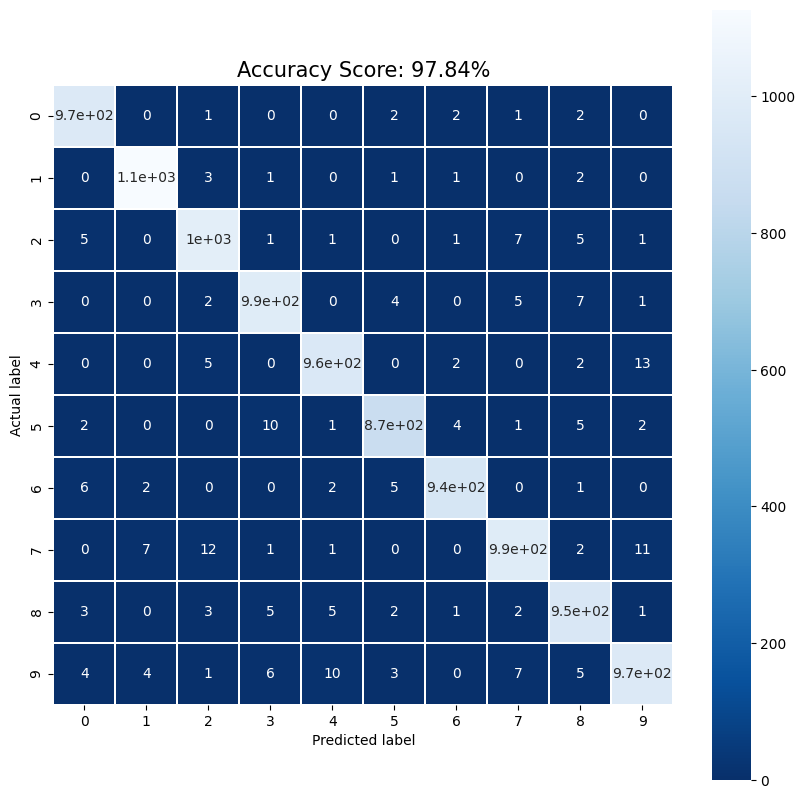

In [15]:
cm = metrics.confusion_matrix(test_y, predicion_svc)
plt.figure(figsize=(10,10))
seaborn.heatmap(cm, annot=True, linewidths=.25, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}%'.format(resultados_svc[0])
plt.title(all_sample_title, size = 15);


# Modelo MLP

## 1. Variables locales

In [16]:
cpu_percent_list_train_mlp = []
memory_usage_list_train_mlp= []
cpu_percent_list_test_mlp= []
memory_usage_list_test_mlp= []


## 2. Funcion para buscar los mejores hiperparámetros

In [17]:
def busqueda_de_atributos_mlp(modelo):
    scoring = 'accuracy'
    param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu','logistic','identity'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive','invscaling'],
    'max_iter':[5000,6000,7000]
}
    
    grid_search_mlp = HalvingGridSearchCV(estimator=modelo, param_grid=param_grid, scoring=scoring, cv=3)
    grid_search_mlp.fit(train_x, train_y)

    return [grid_search_mlp.best_estimator_,grid_search_mlp.best_params_]

## 3. Funciones para monitorización de cpu y ram

In [18]:
def lists_cpu_and_ram_mlp_train():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_mlp.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_mlp.append(currentProcess.memory_percent())
        
def start_mlp_train():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_mlp_train)
    t.start()

def stop_mlp_train():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

In [19]:
def lists_cpu_and_ram_mlp_test():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_mlp.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_mlp.append(currentProcess.memory_percent())
        
def start_mlp_test():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_mlp_test)
    t.start()

def stop_mlp_test():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

## 4. Funcion para entrenar y testear el modelo

In [20]:
def entrenamientoyresultados_mlp(modelo):
    
    clf_mlp = modelo
    #Empezamos a contar el tiempo de entrenamiento
    startTrainingTime_mlp = time.time()
    
    # Entrenamiento
    start_mlp_train()
    try:
        clf_mlp.fit(train_x, train_y)
    finally:
        stop_mlp_train()


    #Terminamos de contar el tiempo de entrenamiento
    endTrainingTime_mlp = time.time()

    #Calculamos el tiempo de entrenamiento
    trainingTime_mlp = endTrainingTime_mlp - startTrainingTime_mlp  

    validResults_mlp = 0

    #Empezamos a contar el tiempo de testeo
    
    startTestingTime_mlp = time.time()
    
    start_mlp_test()
    try:
        for i in range(len(test_y)):


            expectedResult_mlp = int(test_y[int(i)])
            result_mlp = int(clf_mlp.predict(test_x[int(i)].reshape(1, len(test_x[int(i)]))))

            outcome = "Fail"

            if result_mlp == expectedResult_mlp:

                validResults_mlp = validResults_mlp + 1 

                outcome = " OK "

            print("Nº ", i + 1, " | Expected result: ", expectedResult_mlp, " | Obtained result: ", result_mlp, " | ", outcome,
                  " | Accuracy: ", round((validResults_mlp / (i + 1)) * 100, 2),
                  "%")  # Printing the results for each label in testing dataset
    finally:
        stop_mlp_test()
    
    #Terminamos de contar el tiempo de testeo
    endTestingTime_mlp = time.time()

    #Calculamos el tiempo de testeo
    testingTime_mlp = endTestingTime_mlp - startTestingTime_mlp  # Calculation of testing time
    
    precision_mlp = round((validResults_mlp / testingSamples) * 100, 2)
    
    return precision_mlp,trainingTime_mlp, testingTime_mlp,clf_mlp

## 5. Resultados

In [21]:
#parametros_mlp = busqueda_de_atributos_mlp(MLPClassifier())
modelo_mlp = MLPClassifier(alpha=0.05, max_iter=7000,activation = 'relu', hidden_layer_sizes= (100,100,), solver = 'adam', learning_rate = 'adaptive')
resultados_mlp = entrenamientoyresultados_mlp(modelo_mlp)

Nº  1  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  100.0 %
Nº  2  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  100.0 %
Nº  3  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  100.0 %
Nº  4  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  100.0 %
Nº  5  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  100.0 %
Nº  6  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  100.0 %
Nº  7  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  100.0 %
Nº  8  | Expected result:  5  | Obtained result:  6  |  Fail  | Accuracy:  87.5 %
Nº  9  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  88.89 %
Nº  10  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  90.0 %
Nº  11  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  90.91 %
Nº  12  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  91.67 %
Nº 

Nº  427  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  98.13 %
Nº  428  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  98.13 %
Nº  429  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  98.14 %
Nº  430  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  98.14 %
Nº  431  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  98.14 %
Nº  432  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  98.15 %
Nº  433  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  98.15 %
Nº  434  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  98.16 %
Nº  435  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  98.16 %
Nº  436  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  98.17 %
Nº  437  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  98.17 %
Nº  438  | Expected result:  7  | Obtained result:  7  |   OK   |

Nº  824  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.69 %
Nº  825  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.7 %
Nº  826  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.7 %
Nº  827  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.7 %
Nº  828  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.71 %
Nº  829  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.71 %
Nº  830  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.71 %
Nº  831  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.71 %
Nº  832  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.72 %
Nº  833  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.72 %
Nº  834  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.72 %
Nº  835  | Expected result:  1  | Obtained result:  1  |   OK   | Ac

Nº  1231  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.08 %
Nº  1232  | Expected result:  9  | Obtained result:  4  |  Fail  | Accuracy:  97.0 %
Nº  1233  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.0 %
Nº  1234  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.0 %
Nº  1235  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.0 %
Nº  1236  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.01 %
Nº  1237  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.01 %
Nº  1238  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.01 %
Nº  1239  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.01 %
Nº  1240  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.02 %
Nº  1241  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.02 %
Nº  1242  | Expected result:  4  | Obtained result:  4  | 

Nº  1647  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.9 %
Nº  1648  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.91 %
Nº  1649  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.91 %
Nº  1650  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  96.91 %
Nº  1651  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  96.91 %
Nº  1652  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  96.91 %
Nº  1653  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  96.91 %
Nº  1654  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.92 %
Nº  1655  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  96.92 %
Nº  1656  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  96.92 %
Nº  1657  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  96.92 %
Nº  1658  | Expected result:  2  | Obtained result:  2 

Nº  2015  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.22 %
Nº  2016  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.22 %
Nº  2017  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.22 %
Nº  2018  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.22 %
Nº  2019  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.23 %
Nº  2020  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.23 %
Nº  2021  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.23 %
Nº  2022  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.23 %
Nº  2023  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.23 %
Nº  2024  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.23 %
Nº  2025  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.23 %
Nº  2026  | Expected result:  6  | Obtained result:  6

Nº  2617  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.02 %
Nº  2618  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.02 %
Nº  2619  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.02 %
Nº  2620  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.02 %
Nº  2621  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.02 %
Nº  2622  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.03 %
Nº  2623  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.03 %
Nº  2624  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.03 %
Nº  2625  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.03 %
Nº  2626  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.03 %
Nº  2627  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.03 %
Nº  2628  | Expected result:  7  | Obtained result:  7

Nº  2845  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.15 %
Nº  2846  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.15 %
Nº  2847  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.15 %
Nº  2848  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.16 %
Nº  2849  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.16 %
Nº  2850  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.16 %
Nº  2851  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.16 %
Nº  2852  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.16 %
Nº  2853  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.16 %
Nº  2854  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.16 %
Nº  2855  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.16 %
Nº  2856  | Expected result:  8  | Obtained result:  8

Nº  3081  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.11 %
Nº  3082  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.11 %
Nº  3083  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.11 %
Nº  3084  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.11 %
Nº  3085  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.12 %
Nº  3086  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.12 %
Nº  3087  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.12 %
Nº  3088  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.12 %
Nº  3089  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.12 %
Nº  3090  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.12 %
Nº  3091  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.12 %
Nº  3092  | Expected result:  1  | Obtained result:  1

Nº  3358  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.29 %
Nº  3359  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.29 %
Nº  3360  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.29 %
Nº  3361  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.29 %
Nº  3362  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.29 %
Nº  3363  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.29 %
Nº  3364  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.29 %
Nº  3365  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.3 %
Nº  3366  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.3 %
Nº  3367  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.3 %
Nº  3368  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.3 %
Nº  3369  | Expected result:  9  | Obtained result:  9  | 

Nº  3574  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.26 %
Nº  3575  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.26 %
Nº  3576  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.26 %
Nº  3577  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.26 %
Nº  3578  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.26 %
Nº  3579  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.26 %
Nº  3580  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.26 %
Nº  3581  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.26 %
Nº  3582  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.26 %
Nº  3583  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.26 %
Nº  3584  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.27 %
Nº  3585  | Expected result:  7  | Obtained result:  7

Nº  3844  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.27 %
Nº  3845  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.27 %
Nº  3846  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.27 %
Nº  3847  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.27 %
Nº  3848  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.27 %
Nº  3849  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.27 %
Nº  3850  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.27 %
Nº  3851  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.27 %
Nº  3852  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.27 %
Nº  3853  | Expected result:  6  | Obtained result:  0  |  Fail  | Accuracy:  97.25 %
Nº  3854  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.25 %
Nº  3855  | Expected result:  5  | Obtained result:  5

Nº  4106  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.22 %
Nº  4107  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.22 %
Nº  4108  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.22 %
Nº  4109  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.23 %
Nº  4110  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.23 %
Nº  4111  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.23 %
Nº  4112  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.23 %
Nº  4113  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.23 %
Nº  4114  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.23 %
Nº  4115  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.23 %
Nº  4116  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.23 %
Nº  4117  | Expected result:  8  | Obtained result:  8

Nº  4426  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.2 %
Nº  4427  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.2 %
Nº  4428  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.2 %
Nº  4429  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.2 %
Nº  4430  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.2 %
Nº  4431  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.2 %
Nº  4432  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.2 %
Nº  4433  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.2 %
Nº  4434  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.2 %
Nº  4435  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.2 %
Nº  4436  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.2 %
Nº  4437  | Expected result:  3  | Obtained result:  3  |   OK   

Nº  4868  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.27 %
Nº  4869  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.27 %
Nº  4870  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.27 %
Nº  4871  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.27 %
Nº  4872  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.27 %
Nº  4873  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.27 %
Nº  4874  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.27 %
Nº  4875  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.27 %
Nº  4876  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.27 %
Nº  4877  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.27 %
Nº  4878  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.27 %
Nº  4879  | Expected result:  8  | Obtained result:  8

Nº  5261  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.41 %
Nº  5262  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.42 %
Nº  5263  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.42 %
Nº  5264  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.42 %
Nº  5265  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.42 %
Nº  5266  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.42 %
Nº  5267  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.42 %
Nº  5268  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.42 %
Nº  5269  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.42 %
Nº  5270  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.42 %
Nº  5271  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.42 %
Nº  5272  | Expected result:  2  | Obtained result:  2

Nº  5716  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.53 %
Nº  5717  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.53 %
Nº  5718  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.53 %
Nº  5719  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.53 %
Nº  5720  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.53 %
Nº  5721  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.54 %
Nº  5722  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.54 %
Nº  5723  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.54 %
Nº  5724  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.54 %
Nº  5725  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.54 %
Nº  5726  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.54 %
Nº  5727  | Expected result:  6  | Obtained result:  6

Nº  6121  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.52 %
Nº  6122  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.52 %
Nº  6123  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.52 %
Nº  6124  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.52 %
Nº  6125  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.52 %
Nº  6126  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.52 %
Nº  6127  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.52 %
Nº  6128  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.52 %
Nº  6129  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.52 %
Nº  6130  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.52 %
Nº  6131  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.52 %
Nº  6132  | Expected result:  2  | Obtained result:  2

Nº  6547  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.68 %
Nº  6548  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.68 %
Nº  6549  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.68 %
Nº  6550  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.68 %
Nº  6551  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.68 %
Nº  6552  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.68 %
Nº  6553  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.68 %
Nº  6554  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.68 %
Nº  6555  | Expected result:  8  | Obtained result:  9  |  Fail  | Accuracy:  97.67 %
Nº  6556  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.67 %
Nº  6557  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.67 %
Nº  6558  | Expected result:  6  | Obtained result:  6

Nº  6960  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.73 %
Nº  6961  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.73 %
Nº  6962  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.73 %
Nº  6963  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.73 %
Nº  6964  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.73 %
Nº  6965  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.73 %
Nº  6966  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.73 %
Nº  6967  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.73 %
Nº  6968  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.73 %
Nº  6969  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.73 %
Nº  6970  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.73 %
Nº  6971  | Expected result:  0  | Obtained result:  0

Nº  7324  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.83 %
Nº  7325  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.83 %
Nº  7326  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.83 %
Nº  7327  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.83 %
Nº  7328  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.83 %
Nº  7329  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.83 %
Nº  7330  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.83 %
Nº  7331  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.83 %
Nº  7332  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.83 %
Nº  7333  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.83 %
Nº  7334  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.83 %
Nº  7335  | Expected result:  6  | Obtained result:  6

Nº  7734  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.93 %
Nº  7735  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.93 %
Nº  7736  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.93 %
Nº  7737  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.93 %
Nº  7738  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.93 %
Nº  7739  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.93 %
Nº  7740  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.93 %
Nº  7741  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.93 %
Nº  7742  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.93 %
Nº  7743  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.93 %
Nº  7744  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.93 %
Nº  7745  | Expected result:  8  | Obtained result:  8

Nº  8136  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.98 %
Nº  8137  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  97.98 %
Nº  8138  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  97.98 %
Nº  8139  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  97.99 %
Nº  8140  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  97.99 %
Nº  8141  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  97.99 %
Nº  8142  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  97.99 %
Nº  8143  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  97.99 %
Nº  8144  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  97.99 %
Nº  8145  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  97.99 %
Nº  8146  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  97.99 %
Nº  8147  | Expected result:  8  | Obtained result:  8

Nº  8569  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  98.02 %
Nº  8570  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  98.02 %
Nº  8571  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  98.02 %
Nº  8572  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  98.02 %
Nº  8573  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  98.02 %
Nº  8574  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  98.02 %
Nº  8575  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  98.02 %
Nº  8576  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  98.02 %
Nº  8577  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  98.02 %
Nº  8578  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  98.02 %
Nº  8579  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  98.02 %
Nº  8580  | Expected result:  6  | Obtained result:  6

Nº  9001  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  98.11 %
Nº  9002  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  98.11 %
Nº  9003  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  98.11 %
Nº  9004  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  98.11 %
Nº  9005  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  98.11 %
Nº  9006  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  98.11 %
Nº  9007  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  98.11 %
Nº  9008  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  98.11 %
Nº  9009  | Expected result:  7  | Obtained result:  2  |  Fail  | Accuracy:  98.1 %
Nº  9010  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  98.1 %
Nº  9011  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  98.1 %
Nº  9012  | Expected result:  4  | Obtained result:  4  |

Nº  9401  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  98.16 %
Nº  9402  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  98.16 %
Nº  9403  | Expected result:  6  | Obtained result:  6  |   OK   | Accuracy:  98.16 %
Nº  9404  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  98.16 %
Nº  9405  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  98.16 %
Nº  9406  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  98.16 %
Nº  9407  | Expected result:  1  | Obtained result:  1  |   OK   | Accuracy:  98.16 %
Nº  9408  | Expected result:  9  | Obtained result:  9  |   OK   | Accuracy:  98.16 %
Nº  9409  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  98.16 %
Nº  9410  | Expected result:  8  | Obtained result:  8  |   OK   | Accuracy:  98.16 %
Nº  9411  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  98.16 %
Nº  9412  | Expected result:  4  | Obtained result:  4

Nº  9864  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  98.07 %
Nº  9865  | Expected result:  0  | Obtained result:  0  |   OK   | Accuracy:  98.07 %
Nº  9866  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  98.07 %
Nº  9867  | Expected result:  2  | Obtained result:  8  |  Fail  | Accuracy:  98.06 %
Nº  9868  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  98.06 %
Nº  9869  | Expected result:  7  | Obtained result:  7  |   OK   | Accuracy:  98.06 %
Nº  9870  | Expected result:  5  | Obtained result:  5  |   OK   | Accuracy:  98.06 %
Nº  9871  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  98.07 %
Nº  9872  | Expected result:  3  | Obtained result:  3  |   OK   | Accuracy:  98.07 %
Nº  9873  | Expected result:  4  | Obtained result:  4  |   OK   | Accuracy:  98.07 %
Nº  9874  | Expected result:  2  | Obtained result:  2  |   OK   | Accuracy:  98.07 %
Nº  9875  | Expected result:  8  | Obtained result:  8

In [22]:
#print("Resultados con parametros: " + str(modelo[1]))
print("-------------------------------")
print("Muestras de entrenamiento: ", trainingSamples)
print("Tiempo de entrenamiento: ", round(resultados_mlp[1], 2), " s")
print("Muestras de testeo: ", testingSamples)
print("Tiempo de testeo: ", round(resultados_mlp[2], 2), " s")
print("Presición: ", resultados_mlp[0], "%")
print("-------------------------------")
print("Uso de CPU en entrenamiento: ", cpu_percent_list_train_mlp)
print("-------------------------------")
print("Uso de CPU en test: ", cpu_percent_list_test_mlp)
print("-------------------------------")
print("Uso de RAM en entrenamiento: ", memory_usage_list_train_mlp)
print("-------------------------------")
print("Uso de RAM en test: ", memory_usage_list_test_mlp)

-------------------------------
Muestras de entrenamiento:  50000
Tiempo de entrenamiento:  95.13  s
Muestras de testeo:  10000
Tiempo de testeo:  6.02  s
Presición:  98.04 %
-------------------------------
Uso de CPU en entrenamiento:  [88.89999999999999, 93.47500000000001, 95.89166666666667, 99.71666666666665, 99.72500000000001, 99.72500000000001, 99.74166666666667, 99.55833333333334, 99.80833333333334, 99.64999999999999, 99.89166666666667, 99.64166666666667, 99.64999999999999, 99.46666666666665, 99.72500000000001, 99.75833333333333, 99.64166666666667, 99.72500000000001, 99.81666666666666, 99.72500000000001, 99.80833333333334, 99.58333333333333, 99.72500000000001, 99.71666666666665, 99.90833333333335, 99.64166666666667, 99.71666666666665, 99.74166666666667, 99.64166666666667, 99.8, 99.75, 99.64166666666667, 99.72500000000001, 99.825, 99.64166666666667, 99.88333333333333, 99.575, 99.63333333333333, 99.64166666666667, 99.75833333333333, 99.72500000000001, 99.80833333333334, 99.65833333

In [33]:
predicion_mlp = resultados_mlp[3].predict(test_x)

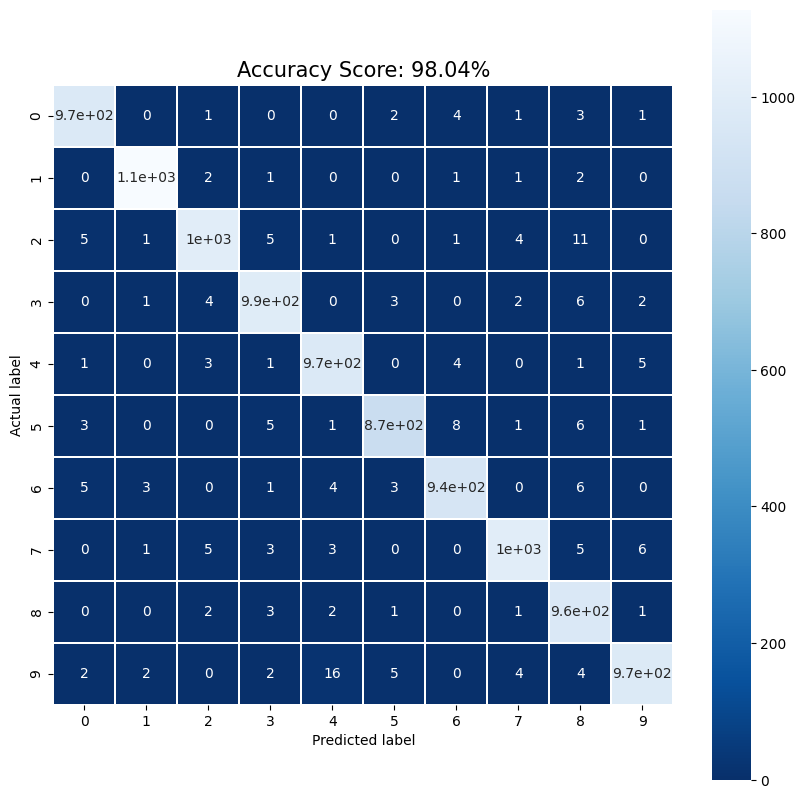

In [34]:
cm = metrics.confusion_matrix(test_y, predicion_mlp)
plt.figure(figsize=(10,10))
seaborn.heatmap(cm, annot=True, linewidths=.25, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}%'.format(resultados_mlp[0])
plt.title(all_sample_title, size = 15);

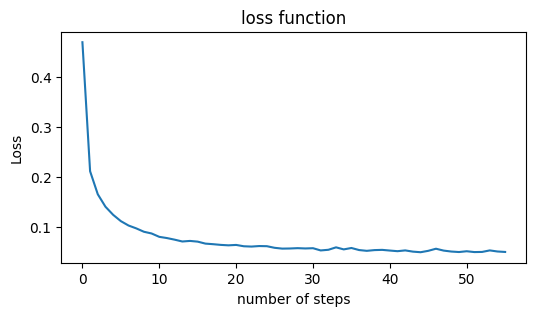

In [35]:
fig, ax = plt.subplots(figsize=(6,3))
modelo = resultados_mlp[3]
ax.plot(modelo.loss_curve_)

plt.xlabel("number of steps") 
plt.ylabel("Loss")
plt.title("loss function")
plt.show()

# 3. Comparaciones

In [24]:
list_classifiers = ['SVC', 'MLP']
val_scores = [resultados_svc[0], resultados_mlp[0]]

In [29]:
trace1 = go.Scatter(x = list_classifiers, y = val_scores,
                   name="Validation", text = list_classifiers)

data = [trace1]

layout = dict(title = "Validation and Submission Scores", 
              xaxis=dict(ticklen=10, zeroline= False),
              yaxis=dict(title = "Accuracy", side='left', ticklen=10,),                                  
              legend=dict(orientation="v", x=1.05, y=1.0),
              autosize=False, width=750, height=500,
              )

fig = dict(data = data, layout = layout)
iplot(fig)

<AxesSubplot: >

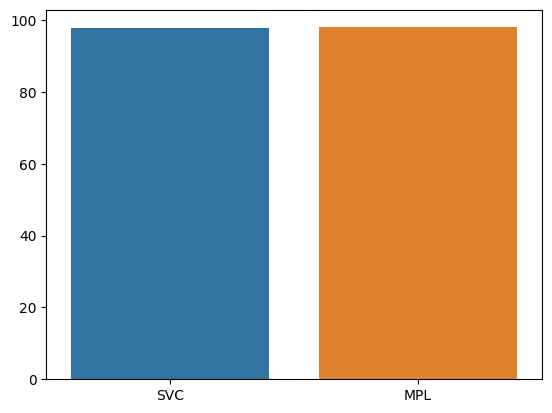

In [30]:
seaborn.barplot(x=["SVC", "MPL"],
            y=[resultados_svc[0], resultados_mlp[0]])

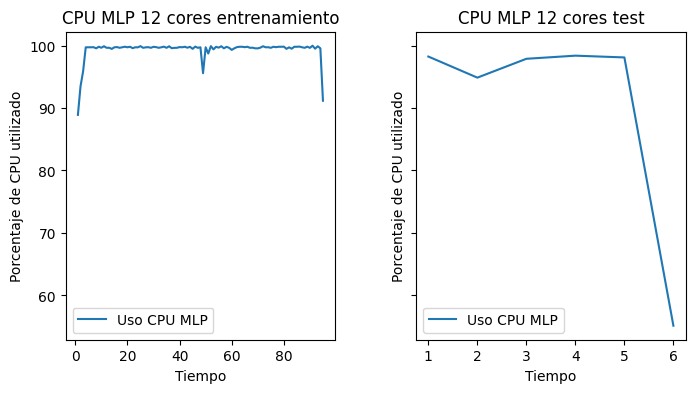

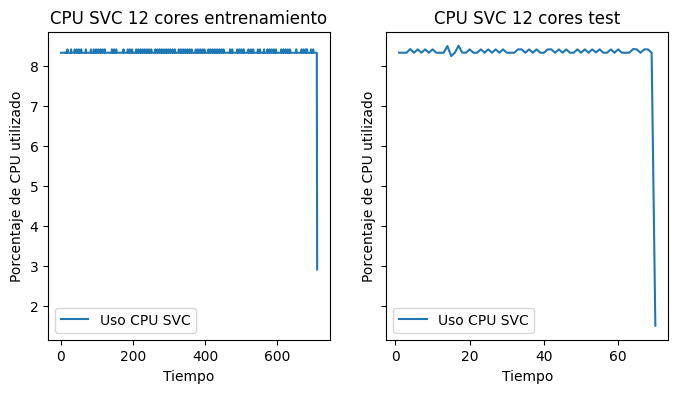

In [70]:
tiempo_entrenamieno_mlp = round(resultados_mlp[1], 2)
tiempo_entrenamiento_svc = round(resultados_svc[1],2)
tiempo_testeo_mlp = round(resultados_mlp[2],2)
tiempo_testeo_svc = round(resultados_svc[2],2)

tiempo_1 = np.arange(1,tiempo_entrenamieno_mlp)
datos_1 = cpu_percent_list_train_mlp

tiempo_2 = np.arange(1,tiempo_testeo_mlp)
datos_2 = cpu_percent_list_test_mlp

datos_3 = cpu_percent_list_train_svc
tiempo_3 = np.arange(1,tiempo_entrenamiento_svc)

datos_4 = cpu_percent_list_test_svc
tiempo_4 = np.arange(1,tiempo_testeo_svc)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
fig.subplots_adjust(wspace=0.3)
ax1.plot(tiempo_1, datos_1, label='Uso CPU MLP')
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Porcentaje de CPU utilizado')
ax1.set_title('CPU MLP 12 cores entrenamiento')
ax1.legend()

ax2.plot(tiempo_2, datos_2, label='Uso CPU MLP')
ax2.set_xlabel('Tiempo')
ax2.set_ylabel('Porcentaje de CPU utilizado')
ax2.set_title('CPU MLP 12 cores test')
ax2.legend()

# Creamos la figura y los ejes de la gráfica para el segundo tiempo
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
ax3.plot(tiempo_3, datos_3, label='Uso CPU SVC')
ax3.set_xlabel('Tiempo')
ax3.set_ylabel('Porcentaje de CPU utilizado')
ax3.set_title('CPU SVC 12 cores entrenamiento')
ax3.legend()

ax4.plot(tiempo_4, datos_4, label='Uso CPU SVC')
ax4.set_xlabel('Tiempo')
ax4.set_ylabel('Porcentaje de CPU utilizado')
ax4.set_title('CPU SVC 12 cores test')
ax4.legend()


# Mostramos ambas gráficas
plt.show()


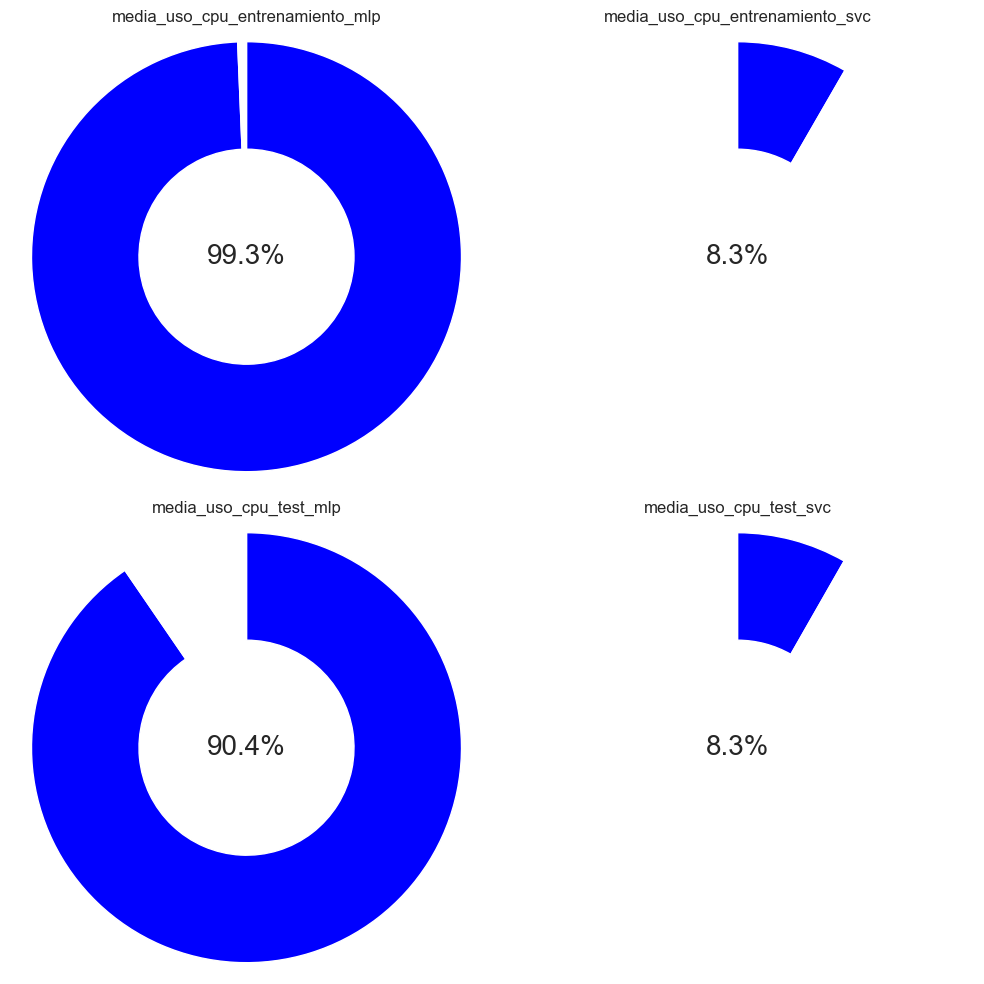

In [98]:
media_uso_cpu_entrenamiento_mlp = np.mean(cpu_percent_list_train_mlp)
media_uso_cpu_entrenamiento_svc = np.mean(cpu_percent_list_train_svc)
media_uso_cpu_test_mlp = np.mean(cpu_percent_list_test_mlp)
media_uso_cpu_test_svc = np.mean(cpu_percent_list_test_svc)
nombres = ['media_uso_cpu_entrenamiento_mlp','media_uso_cpu_entrenamiento_svc','media_uso_cpu_test_mlp','media_uso_cpu_test_svc']
# Creamos los datos para los gráficos
porcentajes = [media_uso_cpu_entrenamiento_mlp, media_uso_cpu_entrenamiento_svc, media_uso_cpu_test_mlp,media_uso_cpu_test_svc]

# Creamos los gráficos circulares con Seaborn
seaborn.set(style='whitegrid')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, porcentaje in enumerate(porcentajes):
    restante = 100 - porcentaje
    datos = [porcentaje, restante]
    row = i // 2
    col = i % 2
    
    axs[row, col].pie(datos, colors=['blue', 'white'], startangle=90, counterclock=False,
               wedgeprops={'width': 0.5, 'edgecolor': 'white'})
    
    axs[row, col].text(0, 0, f'{np.around((porcentaje),1)}%', ha='center', va='center', fontsize=20)
    axs[row, col].axis('equal')
    axs[row, col].set_title(nombres[i])

# Ajustamos la figura y mostramos los gráficos
fig.tight_layout()
plt.show()





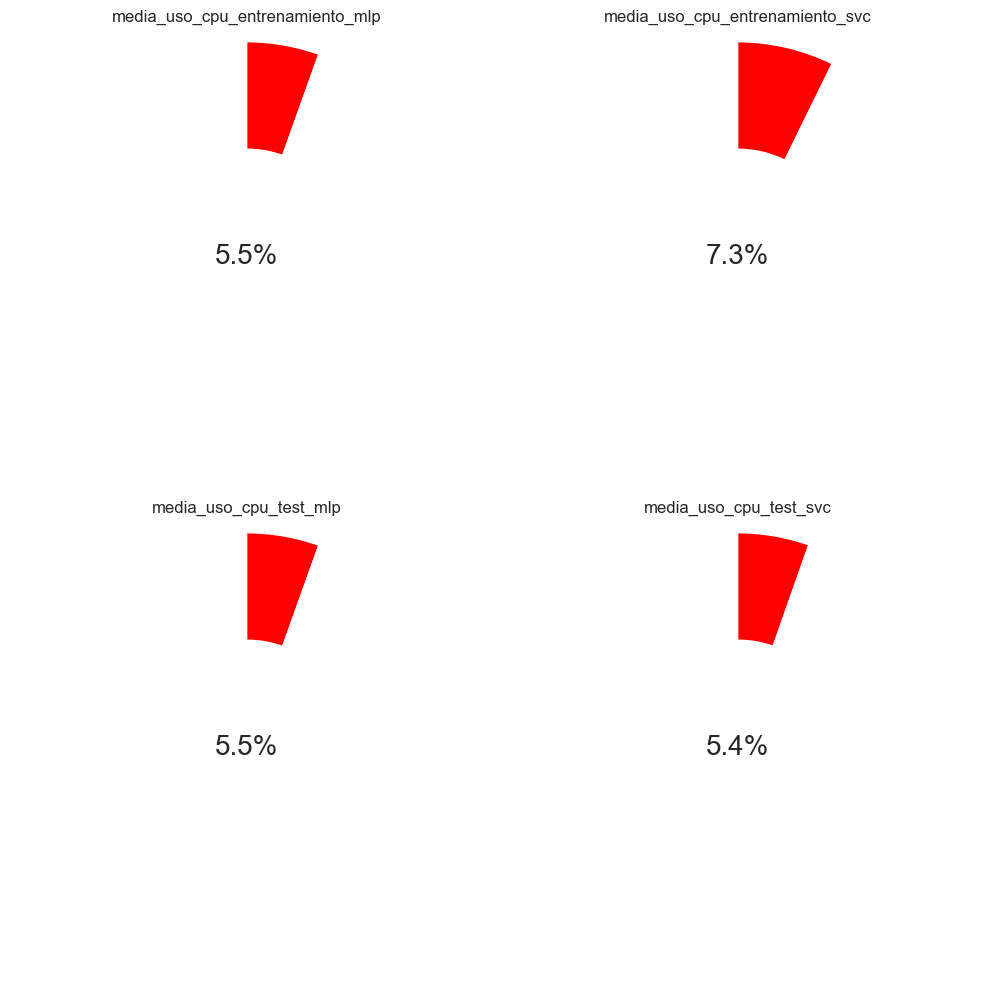

In [101]:
media_uso_ram_entrenamiento_mlp = np.mean(memory_usage_list_train_mlp)
media_uso_ram_entrenamiento_svc = np.mean(memory_usage_list_train_svc)
media_uso_ram_test_mlp = np.mean(memory_usage_list_test_mlp)
media_uso_ram_test_svc = np.mean(memory_usage_list_test_svc)
nombres = ['media_uso_cpu_entrenamiento_mlp','media_uso_cpu_entrenamiento_svc','media_uso_cpu_test_mlp','media_uso_cpu_test_svc']
# Creamos los datos para los gráficos
porcentajes = [media_uso_ram_entrenamiento_mlp, media_uso_ram_entrenamiento_svc, media_uso_ram_test_mlp,media_uso_ram_test_svc]

# Creamos los gráficos circulares con Seaborn
seaborn.set(style='whitegrid')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, porcentaje in enumerate(porcentajes):
    restante = 100 - porcentaje
    datos = [porcentaje, restante]
    row = i // 2
    col = i % 2
    
    axs[row, col].pie(datos, colors=['red', 'white'], startangle=90, counterclock=False,
               wedgeprops={'width': 0.5, 'edgecolor': 'white'})
    
    axs[row, col].text(0, 0, f'{np.around((porcentaje),1)}%', ha='center', va='center', fontsize=20)
    axs[row, col].axis('equal')
    axs[row, col].set_title(nombres[i])

# Ajustamos la figura y mostramos los gráficos
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Tiempo de entrenamiento')

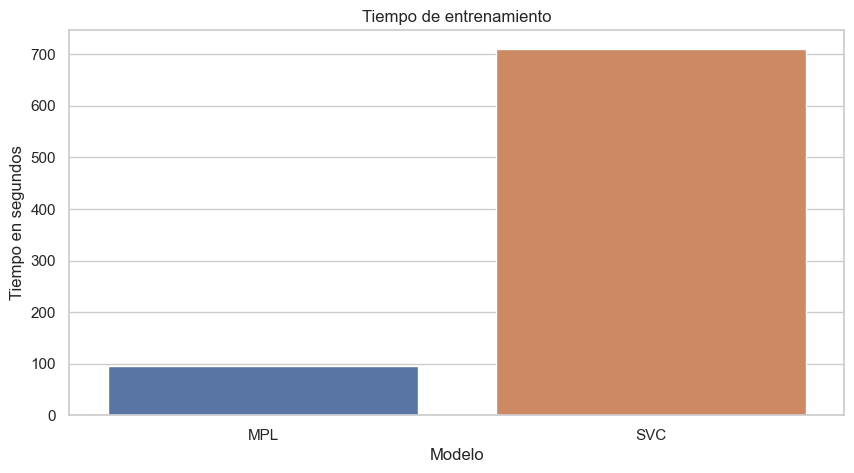

In [132]:
modelos = ["MPL", "SVC"]
counts = [tiempo_entrenamieno_mlp,tiempo_entrenamiento_svc]
fig = plt.figure(dpi=100, figsize=(10,5))
ax = fig.gca()
seaborn.barplot(x=modelos, y=counts, ax=ax, orient="v")
ax.set_ylabel("Tiempo en segundos")
ax.set_xlabel("Modelo")
ax.set_title(f"Tiempo de entrenamiento")

Text(0.5, 1.0, 'Tiempo de entrenamiento')

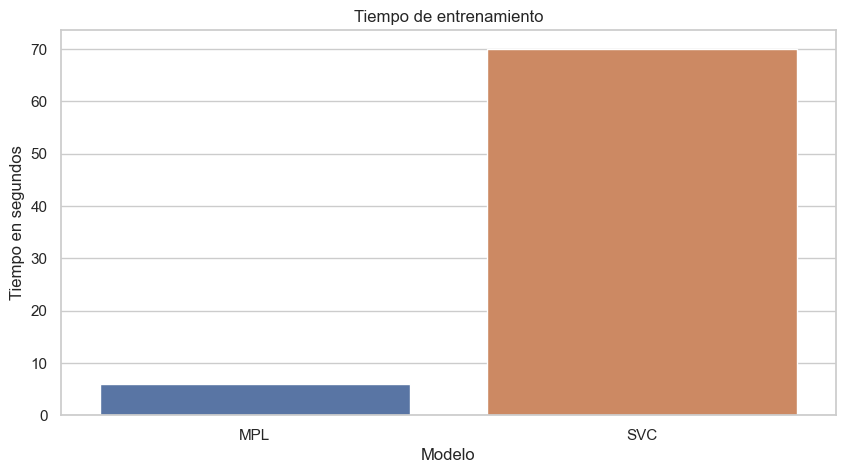

In [133]:
modelos = ["MPL", "SVC"]
counts = [tiempo_testeo_mlp,tiempo_testeo_svc]
fig = plt.figure(dpi=100, figsize=(10,5))
ax = fig.gca()
seaborn.barplot(x=modelos, y=counts, ax=ax, orient="v")
ax.set_ylabel("Tiempo en segundos")
ax.set_xlabel("Modelo")
ax.set_title(f"Tiempo de entrenamiento")